# Bottle Cap Detection and Classification

## Problem Statement

Detect and classify bottle caps into three catagories: dark blue, light blue, and others. Achieve 10 ms inference speed.

## Dataset

Consist of 12 images and their labels. Each image contains multiple bottle caps with same color. The background is constant and controlled.

**Weakness**
- The dataset is too small as a train data for a good deep learning model.
- Lack of diversity in single image. Could potentially cause bias whenever different color of bottle caps are closed. (can be solved by mix up agumentation)
- The background is too constant. Could cause both false positive and negative when doing inference in new environment. (could be a good thing if the model is deployed in the same controlled environment).

## Approaches

I use two approaches for this problem:

**Deep Learning**: YOLO (You Only Look Once) Object Detection. Reasons:
- known for good trade off between inference speed and accuracy
- easy to train

**Traditional Computer Vision**: Hough Circle Transform + HSV Color Analysis. Reasons:
- good at detecting circles in controlled environment
- low computation cost

---
# Approach 1: Deep Learning with YOLO

## Overview

**YOLO (You Only Look Once)** is a state-of-the-art object detection algorithm that:
1. Processes the entire image in one forward pass
2. Predicts bounding boxes and class probabilities simultaneously
3. Achieves real-time performance with high accuracy

### Why YOLO for This Task?

**Advantages:**
- Handles lighting variations, occlusions, deformations
- Learned features can outperform hand-crafted rules
- Adapts to new environments with fine-tuning

**Trade-offs:**
- Less interpretable (unpredictable)
- High computation cost (need training and higher inference time)
- Might perform bad due to small dataset
- Might bias to cluster same color of caps in single image due to how the data is formulated (mozaic and mixup augmentation might help to reduce the bias)

### Architecture: YOLO11

I use **YOLO11n** (nano variant) from Ultralytics:
- Lightweight architecture optimized for speed
- Pre-trained on COCO dataset
- Fine-tuned on bottle cap dataset

## Training Process

### Dataset Split

Since the dataset is too small I use all 12 images both for training and validation.

### Training Configuration

Training is implemented in `bsort/train.py`. Key configuration:

**Model:**
- **Architecture**: YOLO11n (nano - lightweight and fast)
- **Pre-trained**: Yes (COCO dataset weights)
- **Input Size**: 224×224 pixels (originally 640x640. For lower computation cost)

**Training Parameters:**
- **Optimizer**: AdamW (adaptive learning rate)
- **Epochs**: 100 with early stopping (patience=10)
- **Batch Size**: 16
- **Loss Function**: YOLO loss (box regression + classification + distribution focal loss)

**Data Augmentation:**
1. Applied before training to create synthetic data. Implemented in `bsort/augment.py`. Number of augment that I use is 10.

**Geometric Augmentations**
- **Rotation**: ±30°
- **Horizontal Flip**: 0.5
- **Vertical Flip**: 0.3
- **Affine Transform**:
  - **Scale**: 0.8 – 1.2
  - **Translate**: ±10%
  - **Border mode**: constant

**Advanced Augmentations**
- **Gaussian Blur** (kernel 3–7, p=0.3)
- **Gaussian Noise** (std 0.01–0.05, p=0.3)
- **Perspective Distortion** (p=0.2)

2. Applied during training to improve robustness:
- **HSV shifts**: `h=0, s=0, v=0` (to preserve color originality)
- **Translation**: 0.1 (position invariance)
- **Scale**: 0.5 (size invariance)
- **Horizontal flip**: 0.5 (left-right symmetry)
- **Vertical flip**: 0.5 (up-down symmetry)
- **Perspective**: 0.0008
- **Mosaic**: 1.0 (multi-object learning to prevent the model from bias)
- **Mix up**: 0.3 (combine images to prevent model from bias)

### Training Process

```bash
bsort train --config config.yaml
```

**Steps:**
1. Load pre-trained YOLO11 weights
2. Replace classification head for 3 classes
3. Fine-tune on bottle cap dataset
4. Monitor validation mAP@0.5-0.95
5. Save best model based on validation metrics

## Inference Pipeline

For deployment, I use the **ONNX** (Open Neural Network Exchange) format:
- Cross-platform compatibility
- CPU-optimized inference
- No PyTorch dependency

### Inference Steps

1. **Preprocessing**:
   - Resize to 224×224
   - Normalize to [0, 1]
   - Convert to CHW format (Channel-Height-Width)

2. **Model Inference**:
   - Forward pass through ONNX model
   - Output: (1, 7, N) tensor (4 box coords + 3 class logits)

3. **Postprocessing**:
   - Convert boxes from xywh → xyxy
   - Scale boxes to original image size
   - Apply Non-Maximum Suppression (NMS)

Let's implement the YOLO inference pipeline:

In [32]:
import onnxruntime as ort
import torch
import torchvision

def preprocess_yolo(image, input_size=224):
    """Preprocess image for YOLO inference.
    
    Args:
        image: Input image (BGR format)
        input_size: Model input size (default: 224)
    
    Returns:
        (preprocessed_tensor, original_shape)
    """
    original_shape = image.shape[:2]  # (height, width)
    
    # Resize to model input size
    resized = cv2.resize(image, (input_size, input_size))
    
    # Convert BGR → RGB
    rgb = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
    
    # Normalize to [0, 1]
    normalized = rgb.astype(np.float32) / 255.0
    
    # Convert HWC → CHW (Channel-Height-Width)
    chw = np.transpose(normalized, (2, 0, 1))
    
    # Add batch dimension: (1, 3, H, W)
    batched = np.expand_dims(chw, axis=0)
    
    return batched, original_shape


def postprocess_yolo(output, original_shape, input_size=224, 
                     conf_threshold=0.25, iou_threshold=0.45):
    """Postprocess YOLO ONNX output.
    
    Args:
        output: Raw ONNX model output
        original_shape: Original image (height, width)
        input_size: Model input size
        conf_threshold: Confidence threshold
        iou_threshold: NMS IoU threshold
    
    Returns:
        (boxes, scores, class_ids): Filtered detections
    """
    # Squeeze batch dimension
    output = np.squeeze(output)
    
    # Handle different output formats: (7, N) → (N, 7)
    if output.shape[0] < output.shape[-1]:
        output = output.T

    # Split output: [x, y, w, h, class_0, class_1, class_2]
    boxes_xywh = output[:, :4]
    class_probs = output[:, 4:]
    
    # Check if values are in [0,1] range (probabilities) or raw logits
    min_val, max_val = class_probs.min(), class_probs.max()
    
    # If values are outside [0, 1], they are likely logits - apply sigmoid
    if min_val < 0 or max_val > 1:
        class_probs = 1.0 / (1.0 + np.exp(-class_probs))
    
    # Get class with highest probability
    class_ids = np.argmax(class_probs, axis=1)
    scores = np.max(class_probs, axis=1)

    # Filter by confidence threshold
    valid_mask = scores >= conf_threshold
    boxes_xywh_filtered = boxes_xywh[valid_mask]
    scores_filtered = scores[valid_mask]
    class_ids_filtered = class_ids[valid_mask]

    if len(boxes_xywh_filtered) == 0:
        return np.array([]), np.array([]), np.array([])

    # Convert xywh → xyxy format
    boxes_xyxy = np.zeros_like(boxes_xywh_filtered)
    boxes_xyxy[:, 0] = boxes_xywh_filtered[:, 0] - boxes_xywh_filtered[:, 2] / 2  # x1
    boxes_xyxy[:, 1] = boxes_xywh_filtered[:, 1] - boxes_xywh_filtered[:, 3] / 2  # y1
    boxes_xyxy[:, 2] = boxes_xywh_filtered[:, 0] + boxes_xywh_filtered[:, 2] / 2  # x2
    boxes_xyxy[:, 3] = boxes_xywh_filtered[:, 1] + boxes_xywh_filtered[:, 3] / 2  # y2

    # Scale boxes to original image size
    orig_h, orig_w = original_shape
    boxes_xyxy[:, [0, 2]] *= orig_w / input_size
    boxes_xyxy[:, [1, 3]] *= orig_h / input_size

    # Clip to image boundaries
    boxes_xyxy[:, [0, 2]] = np.clip(boxes_xyxy[:, [0, 2]], 0, orig_w)
    boxes_xyxy[:, [1, 3]] = np.clip(boxes_xyxy[:, [1, 3]], 0, orig_h)

    # Apply NMS per class using PyTorch (matches .pt model behavior)
    keep_indices = []
    for class_id in np.unique(class_ids_filtered):
        class_mask = class_ids_filtered == class_id
        class_boxes = boxes_xyxy[class_mask]
        class_scores = scores_filtered[class_mask]
        
        # Convert to PyTorch tensors
        boxes_tensor = torch.from_numpy(class_boxes).float()
        scores_tensor = torch.from_numpy(class_scores).float()
        
        # Apply NMS using PyTorch (same as Ultralytics .pt model)
        nms_indices = torchvision.ops.nms(boxes_tensor, scores_tensor, iou_threshold)
        
        if len(nms_indices) > 0:
            keep_indices.extend(
                np.where(class_mask)[0][nms_indices.numpy()]
            )

    keep_indices = sorted(keep_indices)
    return boxes_xyxy[keep_indices], scores_filtered[keep_indices], class_ids_filtered[keep_indices]


def detect_and_classify_yolo(img_path, model_path):
    """Complete YOLO pipeline for bottle cap detection.
    
    Args:
        img_path: Path to input image
        model_path: Path to ONNX model file
    
    Returns:
        (detections, visualization): List of detections and annotated image
    """
    # Load ONNX model
    session = ort.InferenceSession(
        model_path,
        providers=['CPUExecutionProvider']
    )
    input_name = session.get_inputs()[0].name

    # Load and preprocess image
    img = cv2.imread(img_path)
    preprocessed, original_shape = preprocess_yolo(img, 224)

    # Run inference
    outputs = session.run(None, {input_name: preprocessed})

    # Postprocess
    boxes, scores, class_ids = postprocess_yolo(
        outputs[0], original_shape, 224
    )

    # Format detections
    detections = []
    for box, score, class_id in zip(boxes, scores, class_ids):
        detections.append({
            'bbox': box.tolist(),
            'class_id': int(class_id),
            'confidence': float(score)
        })

    # Visualize
    output = img.copy()
    class_names = ['Dark Blue', 'Light Blue', 'Others']
    color_map = {0: (255, 0, 0), 1: (255, 255, 0), 2: (0, 165, 255)}
    
    for det in detections:
        x1, y1, x2, y2 = map(int, det['bbox'])
        class_id = det['class_id']
        
        # Draw bounding box
        cv2.rectangle(output, (x1, y1), (x2, y2), color_map[class_id], 2)
        
        # Draw label
        label = f"{class_names[class_id]}: {det['confidence']:.2f}"
        cv2.putText(
            output, label, (x1, y1 - 5),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2
        )

    return detections, output


print("YOLO inference pipeline ready!")
print("Note: Using PyTorch NMS to match .pt model behavior")
print("\nTo use:")
print("  1. Set MODEL_PATH to your trained ONNX model")
print("  2. Run: dets, vis = detect_and_classify_yolo(image_path, MODEL_PATH)")
print("\nExample (commented out):")
print('  # MODEL_PATH = "outputs/train/weights/best.onnx"')
print('  # dets, vis = detect_and_classify_yolo("sample/val/images/raw-250110_dc_s001_b4_2.jpg", MODEL_PATH)')
print('  # plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)); plt.show()')

YOLO inference pipeline ready!
Note: Using PyTorch NMS to match .pt model behavior

To use:
  1. Set MODEL_PATH to your trained ONNX model
  2. Run: dets, vis = detect_and_classify_yolo(image_path, MODEL_PATH)

Example (commented out):
  # MODEL_PATH = "outputs/train/weights/best.onnx"
  # dets, vis = detect_and_classify_yolo("sample/val/images/raw-250110_dc_s001_b4_2.jpg", MODEL_PATH)
  # plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)); plt.show()


---
# Approach 2: Traditional Computer Vision

## Overview

The traditional approach uses classical computer vision techniques:
1. **Preprocessing**: Enhance image quality (gamma correction, CLAHE, blur)
2. **Circle Detection**: Hough Circle Transform to find circular objects
3. **Color Classification**: Analyze HSV values inside detected circles

### Advantages
- ✓ No training data required
- ✓ Interpretable parameters and logic
- ✓ Fast inference (typically < 10ms)
- ✓ Low computational requirements

### Limitations
- ✗ Sensitive to parameter tuning
- ✗ Struggles with varying lighting conditions
- ✗ May miss deformed or partially occluded caps
- ✗ Fixed rules may not generalize well

## Step 1: Imports and Helper Functions

In [33]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
from pathlib import Path
import glob

def fast_gamma(image, gamma):
    """Apply gamma correction for brightness adjustment.
    
    Args:
        image: Grayscale image
        gamma: Gamma value (< 1 brightens, > 1 darkens)
    
    Returns:
        Gamma-corrected image
    """
    return (cv2.pow(image / 255.0, gamma) * 255).astype(np.uint8)

def extract_circle_pixels(img, x, y, r):
    """Extract pixels within a circular region.
    
    Args:
        img: Input image
        x, y: Circle center coordinates
        r: Circle radius
    
    Returns:
        (circle_pixels, mask): Masked region and binary mask
    """
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    cv2.circle(mask, (x, y), r, 255, -1)
    circle_pixels = cv2.bitwise_and(img, img, mask=mask)
    return circle_pixels, mask

print("Helper functions loaded successfully!")

Helper functions loaded successfully!


## Step 2: Preprocessing Pipeline

Image preprocessing is crucial for robust circle detection. Our pipeline includes:

### 1. Gamma Correction (γ = 0.5)
- **Purpose**: Brighten dark images to reveal bottle cap edges
- **Effect**: Non-linear brightness adjustment
- **Parameter**: γ < 1 brightens, γ > 1 darkens

### 2. CLAHE (Contrast Limited Adaptive Histogram Equalization)
- **Purpose**: Enhance local contrast without over-amplifying noise
- **Parameters**:
  - `clipLimit=2.0`: Limits contrast enhancement
  - `tileGridSize=(4,4)`: Size of local regions for adaptation

### 3. Gaussian Blur
- **Purpose**: Reduce noise and smooth edges
- **Parameters**:
  - `kernel=(7,7)`: Size of blur kernel
  - `sigma=1.5`: Standard deviation of Gaussian

Let's visualize each preprocessing step:

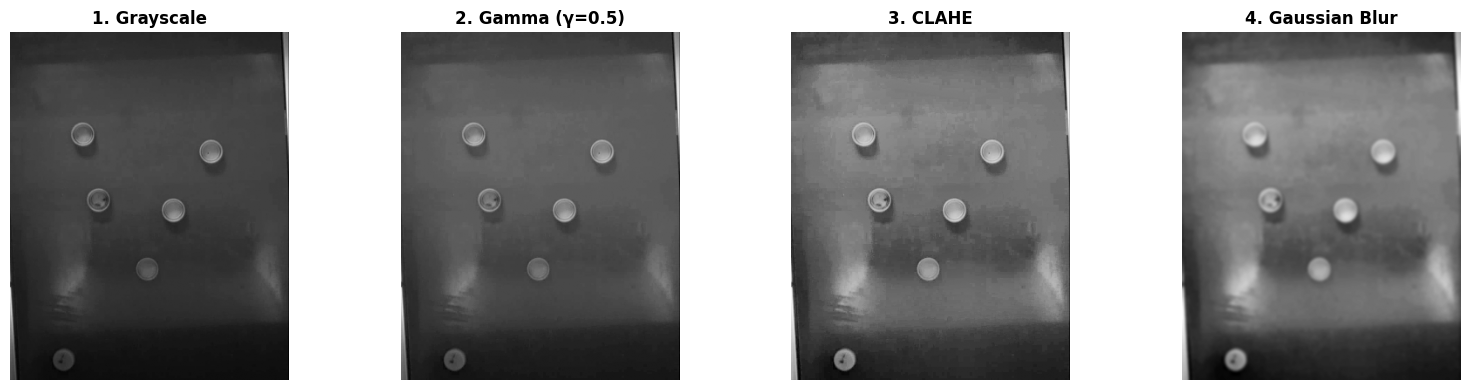

Preprocessing complete! Notice how each step improves edge visibility.


In [34]:
# Load sample image
img = cv2.imread("sample/val/images/raw-250110_dc_s001_b4_2.jpg")
img_small = cv2.resize(img, (0, 0), fx=0.4, fy=0.4)
gray = cv2.cvtColor(img_small, cv2.COLOR_BGR2GRAY)

# Step 1: Gamma correction (brightening)
gray_gamma = fast_gamma(gray, 0.5)

# Step 2: CLAHE (contrast enhancement)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))
gray_eq = clahe.apply(gray_gamma)

# Step 3: Gaussian blur (noise reduction)
gray_blur = cv2.GaussianBlur(gray_eq, (7, 7), 1.5)

# Visualize preprocessing steps
plt.figure(figsize=(16, 4))
plt.subplot(1, 4, 1)
plt.imshow(gray, cmap='gray')
plt.title('1. Grayscale', fontsize=12, fontweight='bold')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(gray_gamma, cmap='gray')
plt.title('2. Gamma (γ=0.5)', fontsize=12, fontweight='bold')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(gray_eq, cmap='gray')
plt.title('3. CLAHE', fontsize=12, fontweight='bold')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(gray_blur, cmap='gray')
plt.title('4. Gaussian Blur', fontsize=12, fontweight='bold')
plt.axis('off')

plt.tight_layout()
plt.show()

print("Preprocessing complete! Notice how each step improves edge visibility.")

## Step 3: Hough Circle Detection

The **Hough Circle Transform** is a feature extraction technique for detecting circles in images.

### Algorithm Overview
1. Apply Canny edge detection
2. For each edge pixel, vote for possible circle centers
3. Find local maxima in the accumulator
4. Return circles exceeding threshold

### Parameter Tuning

Optimized parameters (found through experimentation):

```python
cv2.HoughCircles(
    image,
    cv2.HOUGH_GRADIENT,
    dp=1.2,           # Inverse ratio of accumulator resolution (higher = faster but less precise)
    minDist=25,       # Minimum distance between circle centers (prevents duplicate detections)
    param1=35,        # Canny edge upper threshold (higher = fewer false edges)
    param2=25,        # Accumulator threshold (lower = more sensitive, more false positives)
    minRadius=8,      # Minimum circle radius in pixels (after 0.4x resize)
    maxRadius=16      # Maximum circle radius in pixels (after 0.4x resize)
)
```

### Parameter Trade-offs
- **param1** (Canny threshold): 30-40 works well for preprocessed images
- **param2** (Accumulator): Lower values (20-30) detect more circles but increase false positives
- **minDist**: Set based on expected cap spacing (too low = duplicates, too high = missed caps)
- **Radius range**: Determined from actual cap sizes in resized images

Let's see the detection in action:

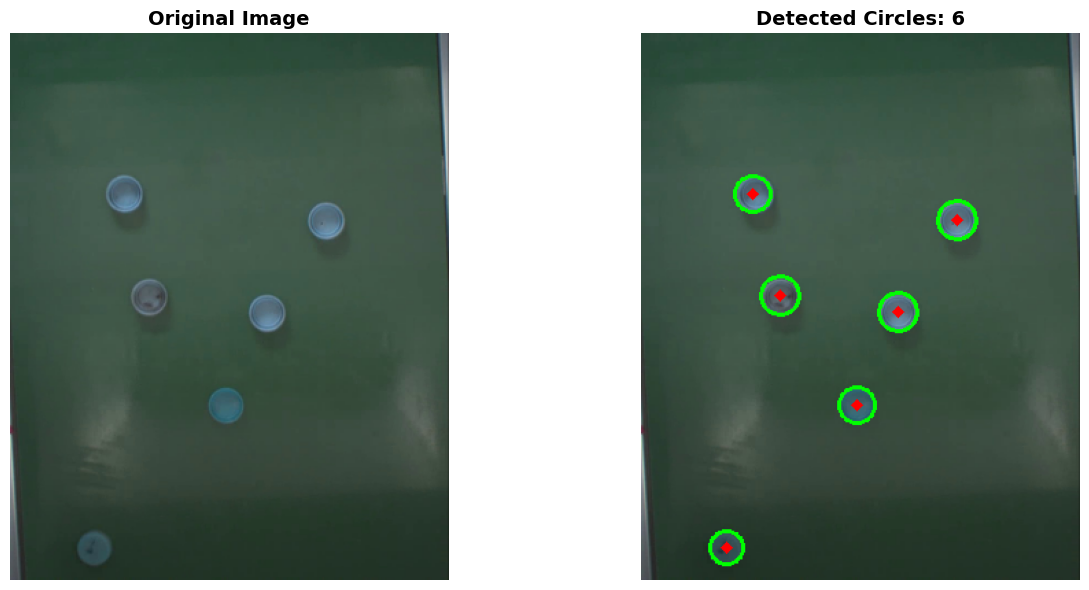

Successfully detected 6 circular objects!


In [35]:
# Detect circles using Hough Transform
circles = cv2.HoughCircles(
    gray_blur,
    cv2.HOUGH_GRADIENT,
    dp=1.2,
    minDist=25,
    param1=35,
    param2=25,
    minRadius=8,
    maxRadius=16
)

# Visualize detected circles
output = img_small.copy()
num_circles = 0

if circles is not None:
    circles = np.uint16(np.around(circles))
    num_circles = len(circles[0])
    
    for (x, y, r) in circles[0]:
        # Draw circle outline (green)
        cv2.circle(output, (x, y), r, (0, 255, 0), 2)
        # Draw center point (red)
        cv2.circle(output, (x, y), 2, (0, 0, 255), 3)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB))
plt.title('Original Image', fontsize=14, fontweight='bold')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.title(f'Detected Circles: {num_circles}', fontsize=14, fontweight='bold')
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Successfully detected {num_circles} circular objects!")

## Step 4: Color Classification via HSV Analysis

### Why HSV Color Space?

Unlike RGB, **HSV** (Hue, Saturation, Value) separates color information from brightness:
- **Hue (H)**: Color type (0-180° in OpenCV)
  - Blue range: 85-130°
- **Saturation (S)**: Color intensity (0-255)
- **Value (V)**: Brightness (0-255)

**Advantage**: Hue is largely invariant to lighting changes, making it ideal for color classification.

### Classification Strategy

1. Extract pixels inside each detected circle
2. Convert to HSV and calculate mean Hue value
3. Apply threshold-based classification rules

### Threshold Determination

We determine optimal thresholds by analyzing Hue distributions across labeled samples:

Analyzing HSV values across dataset...


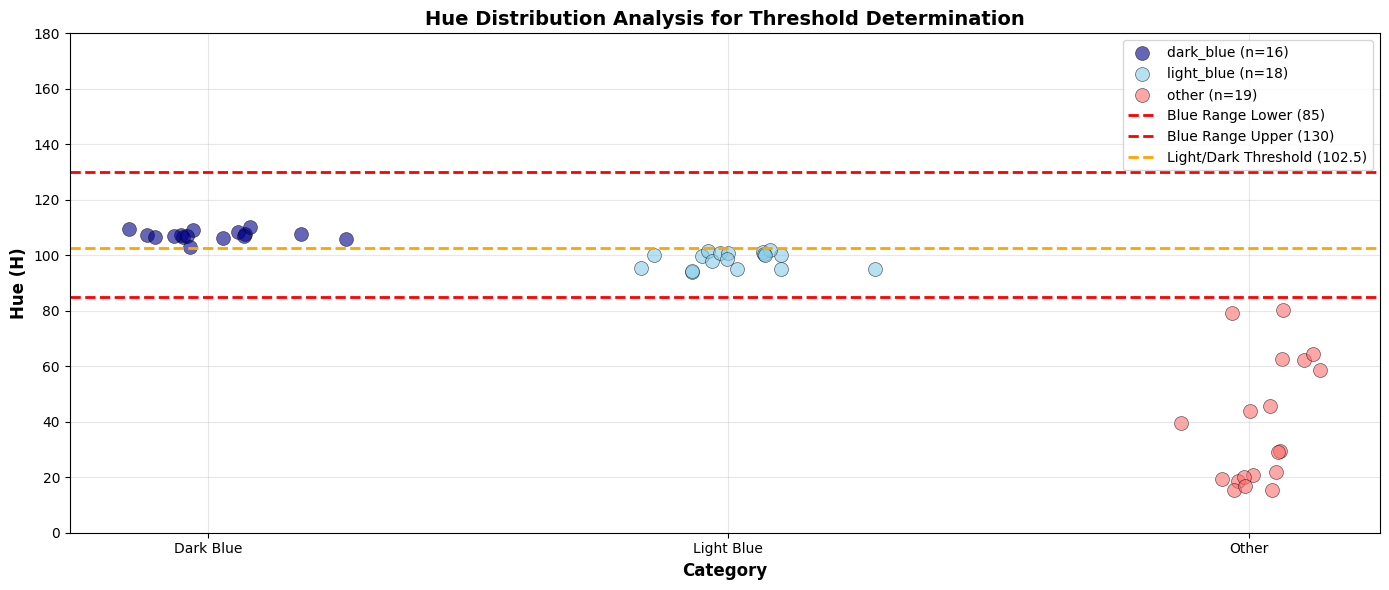


HSV Hue Statistics:
DARK_BLUE    - Mean: 107.2, Std:   1.6, Min: 102.8, Max: 110.3
LIGHT_BLUE   - Mean:  98.4, Std:   2.7, Min:  94.1, Max: 101.8
OTHER        - Mean:  39.1, Std:  21.9, Min:  15.2, Max:  80.3


In [36]:
# Analyze HSV values across labeled dataset
light_blue_images = [
    "sample/val/images/raw-250110_dc_s001_b4_1.jpg",
    "sample/val/images/raw-250110_dc_s001_b4_2.jpg",
    "sample/val/images/raw-250110_dc_s001_b4_3.jpg"
]

dark_blue_images = [
    "sample/val/images/raw-250110_dc_s001_b5_2.jpg",
    "sample/val/images/raw-250110_dc_s001_b5_3.jpg",
    "sample/val/images/raw-250110_dc_s001_b5_5.jpg"
]

other_images = [
    "sample/val/images/raw-250110_dc_s001_b2_1.jpg",
    "sample/val/images/raw-250110_dc_s001_b2_3.jpg",
    "sample/val/images/raw-250110_dc_s001_b3_2.jpg"
]

# Collect HSV statistics
all_h_values = []
all_labels = []

print("Analyzing HSV values across dataset...")

for img_list, label in [(light_blue_images, 'light_blue'),
                         (dark_blue_images, 'dark_blue'),
                         (other_images, 'other')]:
    for img_path in img_list:
        img = cv2.imread(img_path)
        if img is None:
            continue
            
        img_small = cv2.resize(img, (0, 0), fx=0.4, fy=0.4)
        gray = cv2.cvtColor(img_small, cv2.COLOR_BGR2GRAY)
        gray_gamma = fast_gamma(gray, 0.5)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))
        gray_eq = clahe.apply(gray_gamma)
        gray_blur = cv2.GaussianBlur(gray_eq, (7, 7), 1.5)

        circles = cv2.HoughCircles(
            gray_blur, cv2.HOUGH_GRADIENT, dp=1.2, minDist=25,
            param1=35, param2=25, minRadius=8, maxRadius=16
        )

        if circles is not None:
            hsv = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
            for (x, y, r) in np.uint16(np.around(circles[0])):
                circle_pixels, mask = extract_circle_pixels(hsv, x, y, r)
                h_mean = np.mean(circle_pixels[mask > 0, 0])
                all_h_values.append(h_mean)
                all_labels.append(label)

# Visualize Hue distribution
plt.figure(figsize=(14, 6))
colors_map = {'light_blue': '#87CEEB', 'dark_blue': '#00008B', 'other': '#FF6B6B'}

for category in ['dark_blue', 'light_blue', 'other']:
    mask = np.array(all_labels) == category
    h_vals = np.array(all_h_values)[mask]
    x = np.random.normal(
        loc=['dark_blue', 'light_blue', 'other'].index(category),
        scale=0.1,
        size=len(h_vals)
    )
    plt.scatter(
        x, h_vals,
        c=colors_map[category],
        alpha=0.6,
        s=100,
        label=f'{category} (n={len(h_vals)})',
        edgecolors='black',
        linewidth=0.5
    )

plt.ylabel('Hue (H)', fontsize=12, fontweight='bold')
plt.xlabel('Category', fontsize=12, fontweight='bold')
plt.title('Hue Distribution Analysis for Threshold Determination',
          fontsize=14, fontweight='bold')
plt.xticks([0, 1, 2], ['Dark Blue', 'Light Blue', 'Other'])

# Add threshold lines
plt.axhline(y=85, color='red', linestyle='--', linewidth=2, label='Blue Range Lower (85)')
plt.axhline(y=130, color='red', linestyle='--', linewidth=2, label='Blue Range Upper (130)')
plt.axhline(y=102.5, color='orange', linestyle='--', linewidth=2, label='Light/Dark Threshold (102.5)')

plt.ylim(0, 180)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print statistics
print("\nHSV Hue Statistics:")
print("=" * 70)
for category in ['dark_blue', 'light_blue', 'other']:
    mask = np.array(all_labels) == category
    h_vals = np.array(all_h_values)[mask]
    if len(h_vals) > 0:
        print(f"{category.upper():12} - Mean: {h_vals.mean():5.1f}, "
              f"Std: {h_vals.std():5.1f}, Min: {h_vals.min():5.1f}, Max: {h_vals.max():5.1f}")

### Classification Rules

Based on the HSV analysis above, we define the following classification rules:

```python
if H < 85 or H > 130:
    class = "Others"      # Non-blue colors
elif H > 102.5:
    class = "Dark Blue"  # Lighter blue caps
else:
    class = "Light Blue"   # Darker blue caps
```

**Rationale:**
- **H ∈ [85, 130]**: Blue color range in HSV
- **H = 102.5**: Empirical threshold separating light/dark blues
- Outside blue range → classified as "Others"

## Step 5: Complete Traditional CV Pipeline

Now we combine all steps into a complete detection and classification pipeline:

Testing traditional CV pipeline...


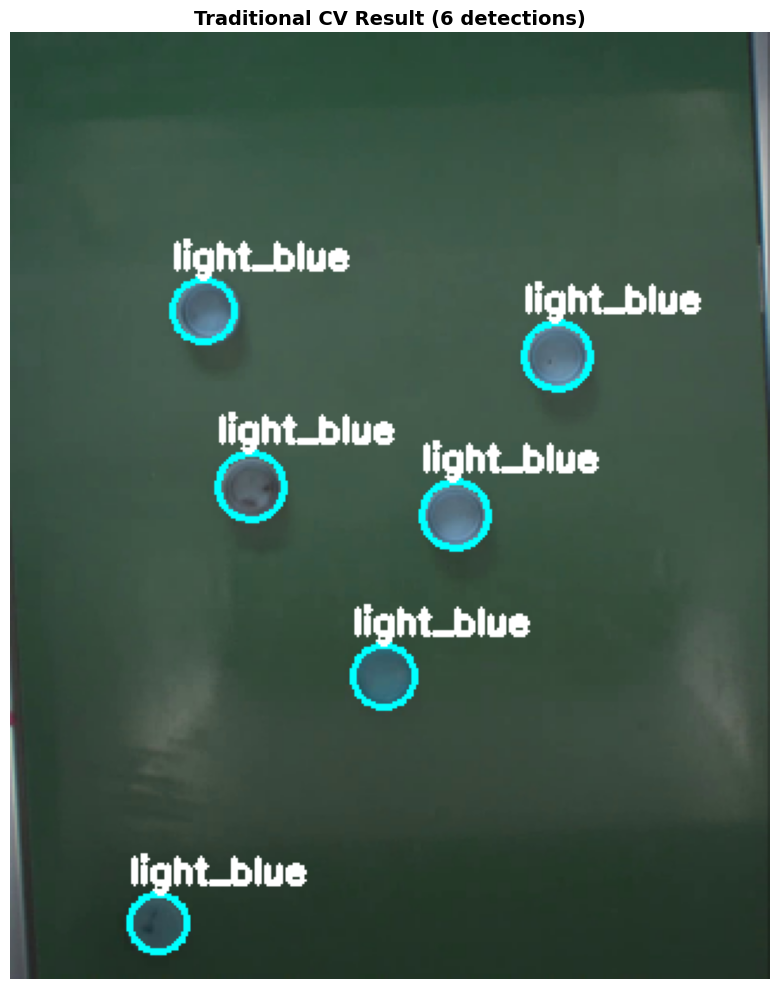


Detected 6 bottle caps!
  Cap 1: Light Blue
  Cap 2: Light Blue
  Cap 3: Light Blue


In [37]:
def classify_blue_color(h):
    """Classify color based on Hue value.
    
    Args:
        h: Mean Hue value (0-180)
    
    Returns:
        Classification label: "light_blue", "dark_blue", or "other"
    """
    if h < 85 or h > 130:
        return "other"
    return "dark_blue" if h > 102.5 else "light_blue"


def detect_and_classify_traditional(img_path):
    """Complete traditional CV pipeline for bottle cap detection.
    
    Args:
        img_path: Path to input image
    
    Returns:
        (detections, visualization): List of detections and annotated image
    """
    # Load and resize image
    img = cv2.imread(img_path)
    img_small = cv2.resize(img, (0, 0), fx=0.4, fy=0.4)

    # Preprocess
    gray = cv2.cvtColor(img_small, cv2.COLOR_BGR2GRAY)
    gray_gamma = fast_gamma(gray, 0.5)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))
    gray_eq = clahe.apply(gray_gamma)
    gray_blur = cv2.GaussianBlur(gray_eq, (7, 7), 1.5)

    # Detect circles
    circles = cv2.HoughCircles(
        gray_blur, cv2.HOUGH_GRADIENT, dp=1.2, minDist=25,
        param1=35, param2=25, minRadius=8, maxRadius=16
    )

    # Classify colors
    detections = []
    output = img_small.copy()
    
    if circles is not None:
        hsv = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
        
        for (x, y, r) in np.uint16(np.around(circles[0])):
            # Extract and classify
            circle_pixels, mask = extract_circle_pixels(hsv, x, y, r)
            h_mean = np.mean(circle_pixels[mask > 0, 0])
            label = classify_blue_color(h_mean)

            # Map to class ID
            class_id_map = {"dark_blue": 0, "light_blue": 1, "other": 2}
            class_id = class_id_map[label]

            # Draw on visualization
            color_map = {0: (255, 0, 0), 1: (255, 255, 0), 2: (0, 165, 255)}
            cv2.circle(output, (x, y), r, color_map[class_id], 2)
            cv2.putText(
                output, label, (x - r, y - r - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2
            )

            # Store detection (scale back to original coordinates)
            scale = 2.5  # 1 / 0.4
            detections.append({
                'bbox': [int((x - r) * scale), int((y - r) * scale),
                        int((x + r) * scale), int((y + r) * scale)],
                'class_id': class_id,
                'confidence': 1.0
            })

    return detections, output


# Test on sample image
print("Testing traditional CV pipeline...")
dets, vis = detect_and_classify_traditional("sample/val/images/raw-250110_dc_s001_b4_2.jpg")

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.title(f'Traditional CV Result ({len(dets)} detections)', fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"\nDetected {len(dets)} bottle caps!")
for i, det in enumerate(dets[:3]):
    class_names = ['Dark Blue', 'Light Blue', 'Others']
    print(f"  Cap {i+1}: {class_names[det['class_id']]}")

---
# Evaluation Framework

## Evaluation Overview

We evaluate both approaches on the validation set using comprehensive metrics:

### 1. Detection Metrics
Measure how well the model localizes objects:
- **Precision**: `TP / (TP + FP)` - ratio of correct detections
- **Recall**: `TP / (TP + FN)` - ratio of detected ground truths
- **F1-Score**: `2 × (Precision × Recall) / (Precision + Recall)`
- **mAP@0.5**: Mean Average Precision at IoU threshold 0.5

### 2. Classification Metrics
Measure color classification accuracy (for correctly localized objects):
- **Per-class Precision/Recall/F1**
- **Confusion Matrix**: Visualize misclassifications
- **Overall Accuracy**: Correctly classified detections

### 3. Performance Metrics
Measure computational efficiency:
- **Inference Time**: Average time per image (ms)
- **FPS**: Frames per second (1000 / avg_time_ms)
- **Standard Deviation**: Consistency of inference speed

### 4. Qualitative Comparison
Visual side-by-side comparison on sample images

### Validation Dataset
- **Size**: 12 images
- **Location**: `sample/val/images/`
- **Ground Truth**: YOLO format labels in `sample/val/labels/`

## Evaluation Utilities

First, let's implement helper functions for evaluation:

In [38]:
def calculate_iou(box1, box2):
    """Calculate IoU (Intersection over Union) between two boxes.
    
    Args:
        box1, box2: Bounding boxes in format [x1, y1, x2, y2]
    
    Returns:
        IoU score (0-1)
    """
    # Intersection coordinates
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # Intersection area
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    
    # Union area
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - intersection

    return intersection / union if union > 0 else 0


def load_yolo_labels(label_path, img_width, img_height):
    """Load YOLO format labels and convert to xyxy format.
    
    Args:
        label_path: Path to .txt label file
        img_width, img_height: Image dimensions
    
    Returns:
        List of boxes: [{'bbox': [x1, y1, x2, y2], 'class_id': int}]
    """
    boxes = []
    
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
                
            class_id = int(parts[0])
            x_center = float(parts[1]) * img_width
            y_center = float(parts[2]) * img_height
            width = float(parts[3]) * img_width
            height = float(parts[4]) * img_height

            # Convert to xyxy
            x1 = x_center - width / 2
            y1 = y_center - height / 2
            x2 = x_center + width / 2
            y2 = y_center + height / 2

            boxes.append({
                'bbox': [x1, y1, x2, y2],
                'class_id': class_id
            })
    
    return boxes


def match_detections(pred_boxes, gt_boxes, iou_threshold=0.5):
    """Match predictions to ground truth using Hungarian matching.
    
    Args:
        pred_boxes: Predicted detections
        gt_boxes: Ground truth boxes
        iou_threshold: Minimum IoU for a match
    
    Returns:
        List of matches: [(pred_idx, gt_idx, iou), ...]
    """
    matches = []
    matched_gt = set()

    # Sort predictions by confidence (if available)
    pred_indices = sorted(
        range(len(pred_boxes)),
        key=lambda i: pred_boxes[i].get('confidence', 1.0),
        reverse=True
    )

    for pred_idx in pred_indices:
        best_iou = 0
        best_gt_idx = -1

        for gt_idx, gt in enumerate(gt_boxes):
            if gt_idx in matched_gt:
                continue

            iou = calculate_iou(
                pred_boxes[pred_idx]['bbox'],
                gt['bbox']
            )
            
            if iou > best_iou and iou >= iou_threshold:
                best_iou = iou
                best_gt_idx = gt_idx

        if best_gt_idx >= 0:
            matches.append((pred_idx, best_gt_idx, best_iou))
            matched_gt.add(best_gt_idx)

    return matches


print("Evaluation utilities loaded!")
print("  - calculate_iou(): Compute IoU between boxes")
print("  - load_yolo_labels(): Load ground truth labels")
print("  - match_detections(): Match predictions to GT")

Evaluation utilities loaded!
  - calculate_iou(): Compute IoU between boxes
  - load_yolo_labels(): Load ground truth labels
  - match_detections(): Match predictions to GT


## Detection Metrics Evaluation

In [39]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

def evaluate_detection_metrics(detect_fn, val_images, iou_threshold=0.5, **detect_kwargs):
    """Evaluate detection metrics (Precision, Recall, mAP).
    
    Args:
        detect_fn: Detection function (traditional or YOLO)
        val_images: List of validation image paths
        iou_threshold: IoU threshold for matching (default: 0.5)
        **detect_kwargs: Additional arguments for detect_fn
    
    Returns:
        (metrics_dict, map_score, all_results)
    """
    all_results = []

    # Process each image
    for img_path in val_images:
        # Get predictions
        detections, _ = detect_fn(img_path, **detect_kwargs)

        # Load ground truth
        img = cv2.imread(img_path)
        h, w = img.shape[:2]
        label_path = img_path.replace('/images/', '/labels/').replace('.jpg', '.txt')
        gt_boxes = load_yolo_labels(label_path, w, h)

        # Match detections to ground truth
        matches = match_detections(detections, gt_boxes, iou_threshold)

        all_results.append({
            'predictions': detections,
            'ground_truth': gt_boxes,
            'matches': matches
        })

    # Calculate metrics per class
    class_names = ['Dark Blue', 'Light Blue', 'Others']
    metrics = {}

    for class_id, class_name in enumerate(class_names):
        total_tp = 0
        total_fp = 0
        total_fn = 0
        total_gt = 0

        for result in all_results:
            # Filter by class
            cls_pred = [p for p in result['predictions'] if p['class_id'] == class_id]
            cls_gt = [g for g in result['ground_truth'] if g['class_id'] == class_id]

            # Count TP: matched predictions of this class
            matched_preds = [
                m[0] for m in result['matches']
                if result['predictions'][m[0]]['class_id'] == class_id
                and result['ground_truth'][m[1]]['class_id'] == class_id
            ]

            tp = len(matched_preds)
            fp = len(cls_pred) - tp
            fn = len(cls_gt) - tp

            total_tp += tp
            total_fp += fp
            total_fn += fn
            total_gt += len(cls_gt)

        # Calculate metrics
        precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
        recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        metrics[class_name] = {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'total_gt': total_gt,
            'total_detected': total_tp + total_fp
        }

    # Calculate mAP (simple average of precisions)
    map_score = np.mean([m['precision'] for m in metrics.values()])

    return metrics, map_score, all_results


print("Detection metrics evaluation ready!")
print("  Metrics: Precision, Recall, F1-score, mAP@0.5")

Detection metrics evaluation ready!
  Metrics: Precision, Recall, F1-score, mAP@0.5


## Classification Metrics Evaluation

In [40]:
def evaluate_classification_metrics(all_results):
    """Compute classification metrics from matched detections.
    
    Args:
        all_results: Results from evaluate_detection_metrics()
    
    Returns:
        (confusion_matrix, classification_report_dict)
    """
    y_true = []
    y_pred = []

    # Extract matched predictions
    for result in all_results:
        for pred_idx, gt_idx, iou in result['matches']:
            y_true.append(result['ground_truth'][gt_idx]['class_id'])
            y_pred.append(result['predictions'][pred_idx]['class_id'])

    if len(y_true) == 0:
        # No matches found
        return np.zeros((3, 3)), {}

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])

    # Classification report
    class_names = ['Dark Blue', 'Light Blue', 'Others']
    report = classification_report(
        y_true, y_pred,
        target_names=class_names,
        output_dict=True,
        zero_division=0
    )

    return cm, report


def plot_confusion_matrix(cm, title):
    """Plot confusion matrix with annotations.
    
    Args:
        cm: Confusion matrix (3×3)
        title: Plot title
    """
    class_names = ['Dark Blue', 'Light Blue', 'Others']
    
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {title}', fontsize=14, fontweight='bold')
    plt.colorbar()

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Add text annotations
    thresh = cm.max() / 2
    for i, j in np.ndindex(cm.shape):
        plt.text(
            j, i, format(cm[i, j], 'd'),
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black",
            fontsize=14
        )

    plt.ylabel('True Label', fontweight='bold')
    plt.xlabel('Predicted Label', fontweight='bold')
    plt.tight_layout()
    plt.show()


print("Classification metrics evaluation ready!")
print("  Metrics: Confusion Matrix, Per-class Precision/Recall/F1")

Classification metrics evaluation ready!
  Metrics: Confusion Matrix, Per-class Precision/Recall/F1


## Performance Benchmarking

In [41]:
def benchmark_performance(detect_fn, val_images, num_runs=3, **detect_kwargs):
    """Benchmark inference speed.
    
    Args:
        detect_fn: Detection function
        val_images: List of validation images
        num_runs: Number of runs per image for averaging
        **detect_kwargs: Additional arguments for detect_fn
    
    Returns:
        Dict with avg_time_ms, std_time_ms, fps, per_image_times
    """
    times = []

    for img_path in val_images:
        img_times = []
        
        for _ in range(num_runs):
            start = time.time()
            detections, _ = detect_fn(img_path, **detect_kwargs)
            end = time.time()
            img_times.append((end - start) * 1000)  # Convert to ms
        
        times.append(np.mean(img_times))

    avg_time = np.mean(times)
    std_time = np.std(times)
    fps = 1000 / avg_time if avg_time > 0 else 0

    return {
        'avg_time_ms': avg_time,
        'std_time_ms': std_time,
        'fps': fps,
        'per_image_times': times
    }


print("Performance benchmarking ready!")
print("  Metrics: Average inference time (ms), FPS")

Performance benchmarking ready!
  Metrics: Average inference time (ms), FPS


## Run Full Evaluation

Now we evaluate both approaches on the validation set.

**IMPORTANT**: Before running this cell, you must:
1. Train a YOLO model or use an existing trained model
2. Export the model to ONNX format
3. Update the `MODEL_PATH` variable below

Evaluating on 12 validation images

EVALUATING TRADITIONAL APPROACH (Hough Circle + HSV)

Computing detection metrics...

Detection Metrics:
----------------------------------------------------------------------
  Dark Blue:
    Precision:  0.938
    Recall:     0.882
    F1-score:   0.909
    GT Objects: 17 | Detected: 16

  Light Blue:
    Precision:  1.000
    Recall:     1.000
    F1-score:   1.000
    GT Objects: 18 | Detected: 18

  Others:
    Precision:  0.932
    Recall:     0.932
    F1-score:   0.932
    GT Objects: 44 | Detected: 44

mAP@0.5: 0.956

Computing classification metrics...

Classification Report:
----------------------------------------------------------------------
  Dark Blue:
    Precision: 1.000
    Recall:    1.000
    F1-score:  1.000
  Light Blue:
    Precision: 1.000
    Recall:    1.000
    F1-score:  1.000
  Others:
    Precision: 1.000
    Recall:    1.000
    F1-score:  1.000



/tmp/ipykernel_438957/684676510.py:62: RuntimeWarning: overflow encountered in scalar subtract
  output, label, (x - r, y - r - 5),


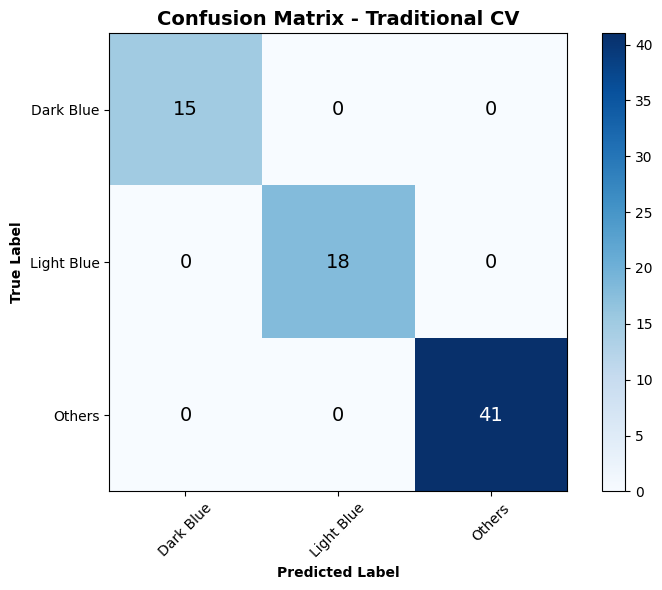

Benchmarking performance...


/tmp/ipykernel_438957/684676510.py:62: RuntimeWarning: overflow encountered in scalar subtract
  output, label, (x - r, y - r - 5),



Performance:
----------------------------------------------------------------------
  Average Time: 8.57 ± 0.90 ms
  FPS:          116.7


EVALUATING YOLO APPROACH

Computing detection metrics...

Detection Metrics:
----------------------------------------------------------------------
  Dark Blue:
    Precision:  0.773
    Recall:     1.000
    F1-score:   0.872
    GT Objects: 17 | Detected: 22

  Light Blue:
    Precision:  1.000
    Recall:     1.000
    F1-score:   1.000
    GT Objects: 18 | Detected: 18

  Others:
    Precision:  0.978
    Recall:     1.000
    F1-score:   0.989
    GT Objects: 44 | Detected: 45

mAP@0.5: 0.917

Computing classification metrics...

Classification Report:
----------------------------------------------------------------------
  Dark Blue:
    Precision: 1.000
    Recall:    1.000
    F1-score:  1.000
  Light Blue:
    Precision: 1.000
    Recall:    1.000
    F1-score:  1.000
  Others:
    Precision: 1.000
    Recall:    1.000
    F1-score:  1.000

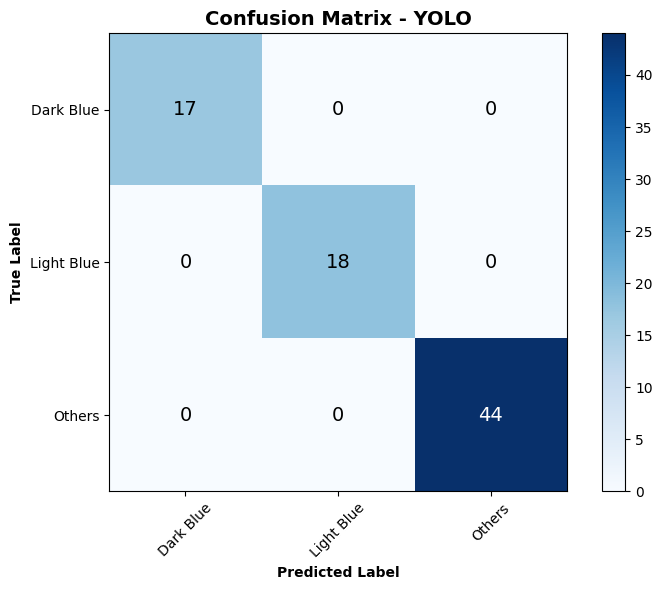

Benchmarking performance...

Performance:
----------------------------------------------------------------------
  Average Time: 59.54 ± 5.28 ms
  FPS:          16.8



In [42]:
# Get validation images
val_images = sorted(glob.glob("sample/val/images/*.jpg"))
print(f"Evaluating on {len(val_images)} validation images")
print()

# ========================================
# USER INPUT REQUIRED
# ========================================
# Provide path to your trained YOLO ONNX model
MODEL_PATH = "run_bsort/train/weights/best.onnx"  # <-- CHANGE THIS PATH
# ========================================

print("=" * 70)
print("EVALUATING TRADITIONAL APPROACH (Hough Circle + HSV)")
print("=" * 70)
print()

# Detection metrics
print("Computing detection metrics...")
trad_metrics, trad_map, trad_results = evaluate_detection_metrics(
    detect_and_classify_traditional, val_images, iou_threshold=0.5
)

print("\nDetection Metrics:")
print("-" * 70)
for class_name, metrics in trad_metrics.items():
    print(f"  {class_name}:")
    print(f"    Precision:  {metrics['precision']:.3f}")
    print(f"    Recall:     {metrics['recall']:.3f}")
    print(f"    F1-score:   {metrics['f1']:.3f}")
    print(f"    GT Objects: {metrics['total_gt']} | Detected: {metrics['total_detected']}")
    print()

print(f"mAP@0.5: {trad_map:.3f}")
print()

# Classification metrics
print("Computing classification metrics...")
trad_cm, trad_report = evaluate_classification_metrics(trad_results)

print("\nClassification Report:")
print("-" * 70)
class_names = ['Dark Blue', 'Light Blue', 'Others']
for cls in class_names:
    if cls in trad_report:
        print(f"  {cls}:")
        print(f"    Precision: {trad_report[cls]['precision']:.3f}")
        print(f"    Recall:    {trad_report[cls]['recall']:.3f}")
        print(f"    F1-score:  {trad_report[cls]['f1-score']:.3f}")

print()
plot_confusion_matrix(trad_cm, "Traditional CV")

# Performance metrics
print("Benchmarking performance...")
trad_perf = benchmark_performance(
    detect_and_classify_traditional, val_images, num_runs=3
)

print("\nPerformance:")
print("-" * 70)
print(f"  Average Time: {trad_perf['avg_time_ms']:.2f} ± {trad_perf['std_time_ms']:.2f} ms")
print(f"  FPS:          {trad_perf['fps']:.1f}")
print()

# ========================================
# YOLO Evaluation
# ========================================
print("\n" + "=" * 70)
print("EVALUATING YOLO APPROACH")
print("=" * 70)
print()

try:
    # Check if model exists
    if not Path(MODEL_PATH).exists():
        print(f"ERROR: Model not found at {MODEL_PATH}")
        print("Please train a model and update MODEL_PATH variable above.")
    else:
        # Detection metrics
        print("Computing detection metrics...")
        yolo_detect_fn = lambda img_path: detect_and_classify_yolo(img_path, MODEL_PATH)
        yolo_metrics, yolo_map, yolo_results = evaluate_detection_metrics(
            yolo_detect_fn, val_images, iou_threshold=0.5
        )

        print("\nDetection Metrics:")
        print("-" * 70)
        for class_name, metrics in yolo_metrics.items():
            print(f"  {class_name}:")
            print(f"    Precision:  {metrics['precision']:.3f}")
            print(f"    Recall:     {metrics['recall']:.3f}")
            print(f"    F1-score:   {metrics['f1']:.3f}")
            print(f"    GT Objects: {metrics['total_gt']} | Detected: {metrics['total_detected']}")
            print()

        print(f"mAP@0.5: {yolo_map:.3f}")
        print()

        # Classification metrics
        print("Computing classification metrics...")
        yolo_cm, yolo_report = evaluate_classification_metrics(yolo_results)

        print("\nClassification Report:")
        print("-" * 70)
        for cls in class_names:
            if cls in yolo_report:
                print(f"  {cls}:")
                print(f"    Precision: {yolo_report[cls]['precision']:.3f}")
                print(f"    Recall:    {yolo_report[cls]['recall']:.3f}")
                print(f"    F1-score:  {yolo_report[cls]['f1-score']:.3f}")

        print()
        plot_confusion_matrix(yolo_cm, "YOLO")

        # Performance metrics
        print("Benchmarking performance...")
        yolo_perf = benchmark_performance(
            yolo_detect_fn, val_images, num_runs=3
        )

        print("\nPerformance:")
        print("-" * 70)
        print(f"  Average Time: {yolo_perf['avg_time_ms']:.2f} ± {yolo_perf['std_time_ms']:.2f} ms")
        print(f"  FPS:          {yolo_perf['fps']:.1f}")
        print()

except Exception as e:
    print(f"Error during YOLO evaluation: {e}")
    print("Make sure MODEL_PATH points to a valid ONNX model.")

## Comparison Summary

Let's create a comprehensive comparison table:

In [43]:
# Check if YOLO evaluation completed successfully
if 'yolo_metrics' in locals():
    # Create comparison dataframe
    comparison_data = {
        'Metric': [
            'mAP@0.5',
            'Light Blue Precision',
            'Light Blue Recall',
            'Light Blue F1',
            'Dark Blue Precision',
            'Dark Blue Recall',
            'Dark Blue F1',
            'Others Precision',
            'Others Recall',
            'Others F1',
            'Avg Inference Time (ms)',
            'FPS'
        ],
        'Traditional CV': [
            f"{trad_map:.3f}",
            f"{trad_metrics['Light Blue']['precision']:.3f}",
            f"{trad_metrics['Light Blue']['recall']:.3f}",
            f"{trad_metrics['Light Blue']['f1']:.3f}",
            f"{trad_metrics['Dark Blue']['precision']:.3f}",
            f"{trad_metrics['Dark Blue']['recall']:.3f}",
            f"{trad_metrics['Dark Blue']['f1']:.3f}",
            f"{trad_metrics['Others']['precision']:.3f}",
            f"{trad_metrics['Others']['recall']:.3f}",
            f"{trad_metrics['Others']['f1']:.3f}",
            f"{trad_perf['avg_time_ms']:.2f}",
            f"{trad_perf['fps']:.1f}"
        ],
        'YOLO': [
            f"{yolo_map:.3f}",
            f"{yolo_metrics['Light Blue']['precision']:.3f}",
            f"{yolo_metrics['Light Blue']['recall']:.3f}",
            f"{yolo_metrics['Light Blue']['f1']:.3f}",
            f"{yolo_metrics['Dark Blue']['precision']:.3f}",
            f"{yolo_metrics['Dark Blue']['recall']:.3f}",
            f"{yolo_metrics['Dark Blue']['f1']:.3f}",
            f"{yolo_metrics['Others']['precision']:.3f}",
            f"{yolo_metrics['Others']['recall']:.3f}",
            f"{yolo_metrics['Others']['f1']:.3f}",
            f"{yolo_perf['avg_time_ms']:.2f}",
            f"{yolo_perf['fps']:.1f}"
        ]
    }

    df_comparison = pd.DataFrame(comparison_data)
    
    print("\n" + "=" * 80)
    print("COMPARISON SUMMARY")
    print("=" * 80)
    print()
    print(df_comparison.to_string(index=False))
    print()
    print("=" * 80)
else:
    print("YOLO evaluation not completed. Comparison table unavailable.")
    print("Please ensure MODEL_PATH is set correctly and re-run the evaluation.")


COMPARISON SUMMARY

                 Metric Traditional CV  YOLO
                mAP@0.5          0.956 0.917
   Light Blue Precision          1.000 1.000
      Light Blue Recall          1.000 1.000
          Light Blue F1          1.000 1.000
    Dark Blue Precision          0.938 0.773
       Dark Blue Recall          0.882 1.000
           Dark Blue F1          0.909 0.872
       Others Precision          0.932 0.978
          Others Recall          0.932 1.000
              Others F1          0.932 0.989
Avg Inference Time (ms)           8.57 59.54
                    FPS          116.7  16.8



## Qualitative Comparison

Let's visualize results side-by-side on sample images:

Side-by-Side Comparison on Sample Images


raw-250110_dc_s001_b2_1.jpg


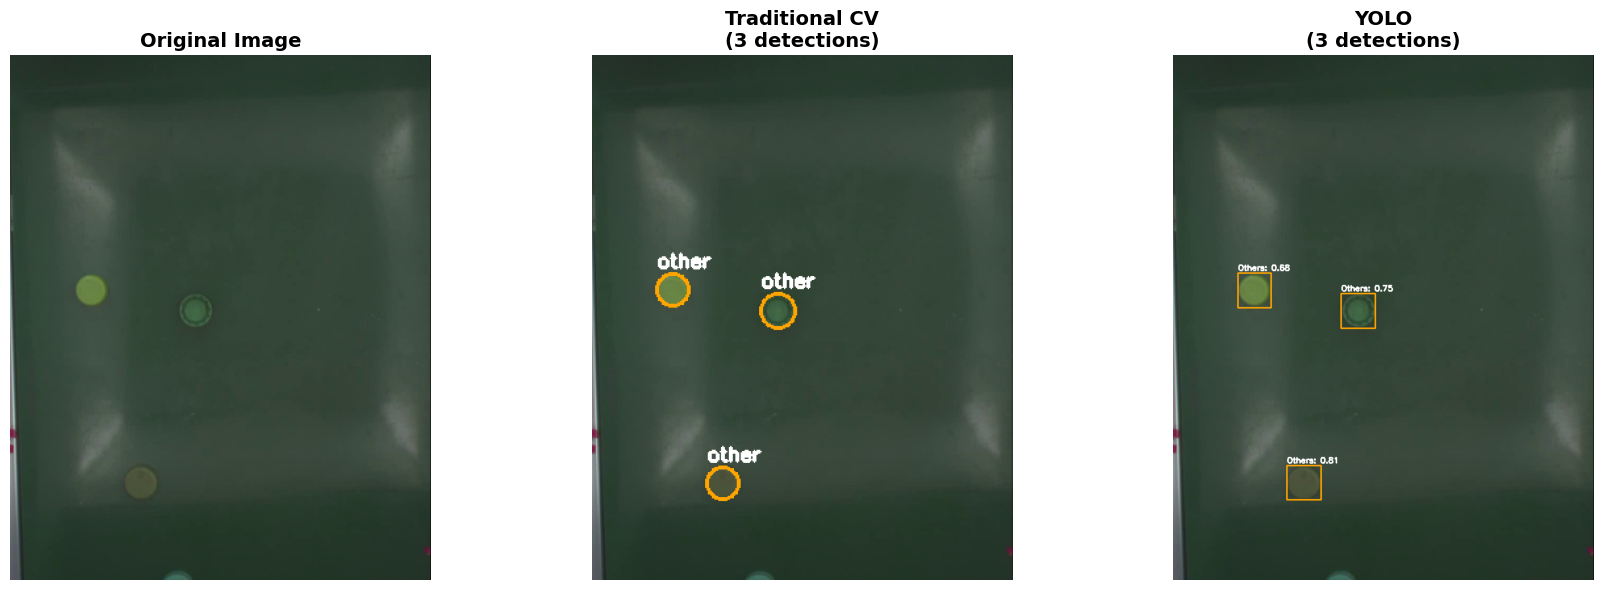


raw-250110_dc_s001_b2_15.jpg


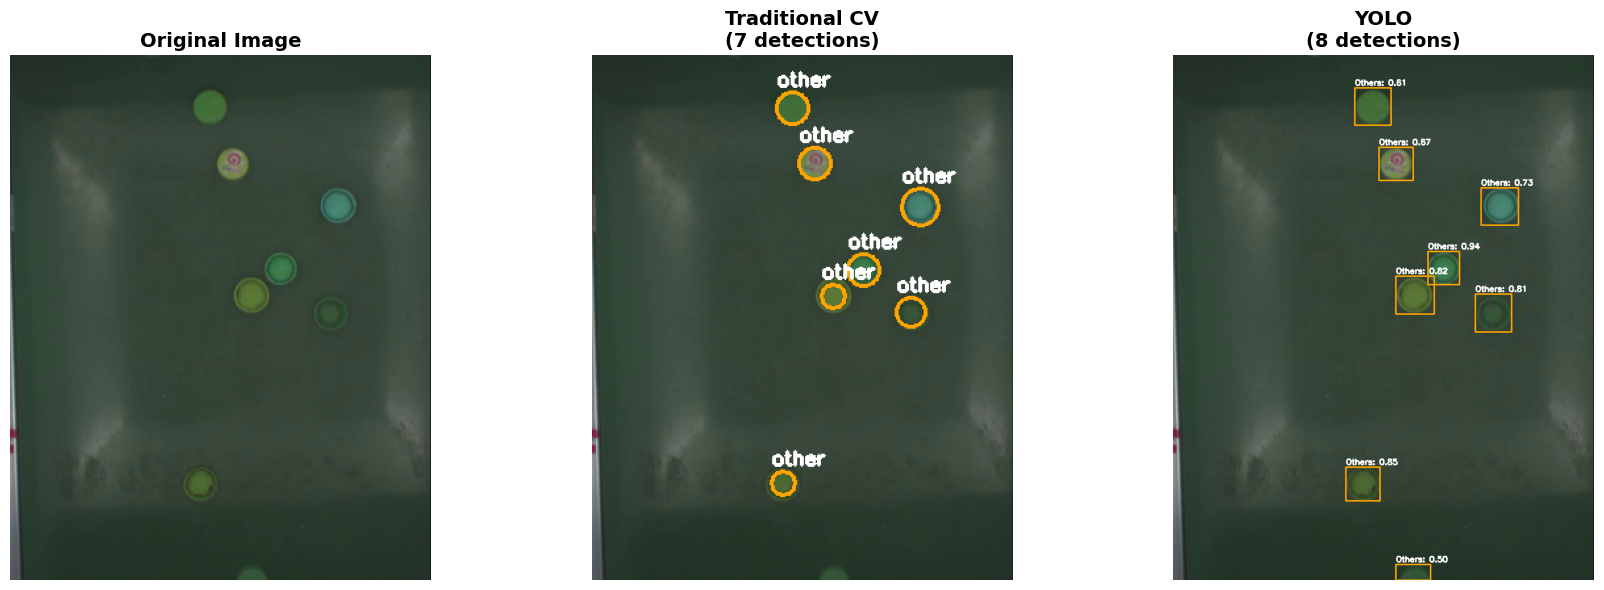


raw-250110_dc_s001_b2_3.jpg


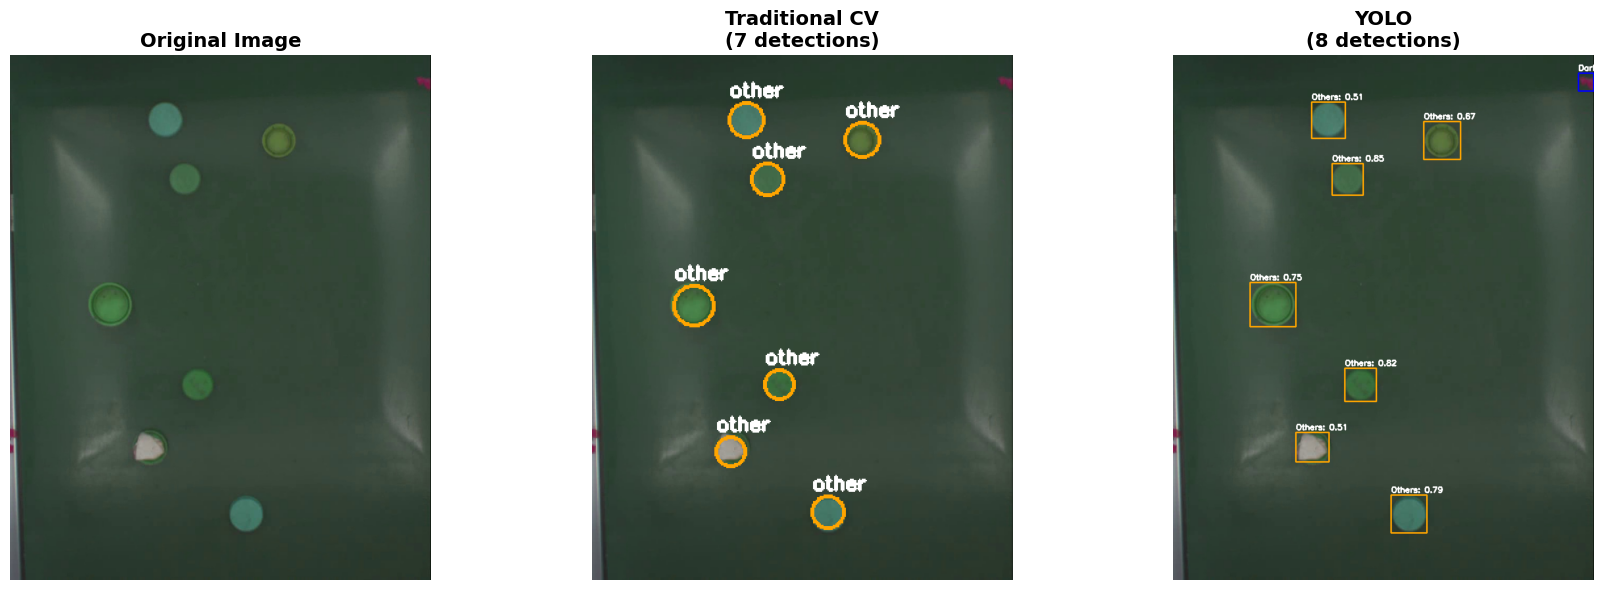


raw-250110_dc_s001_b3_2.jpg


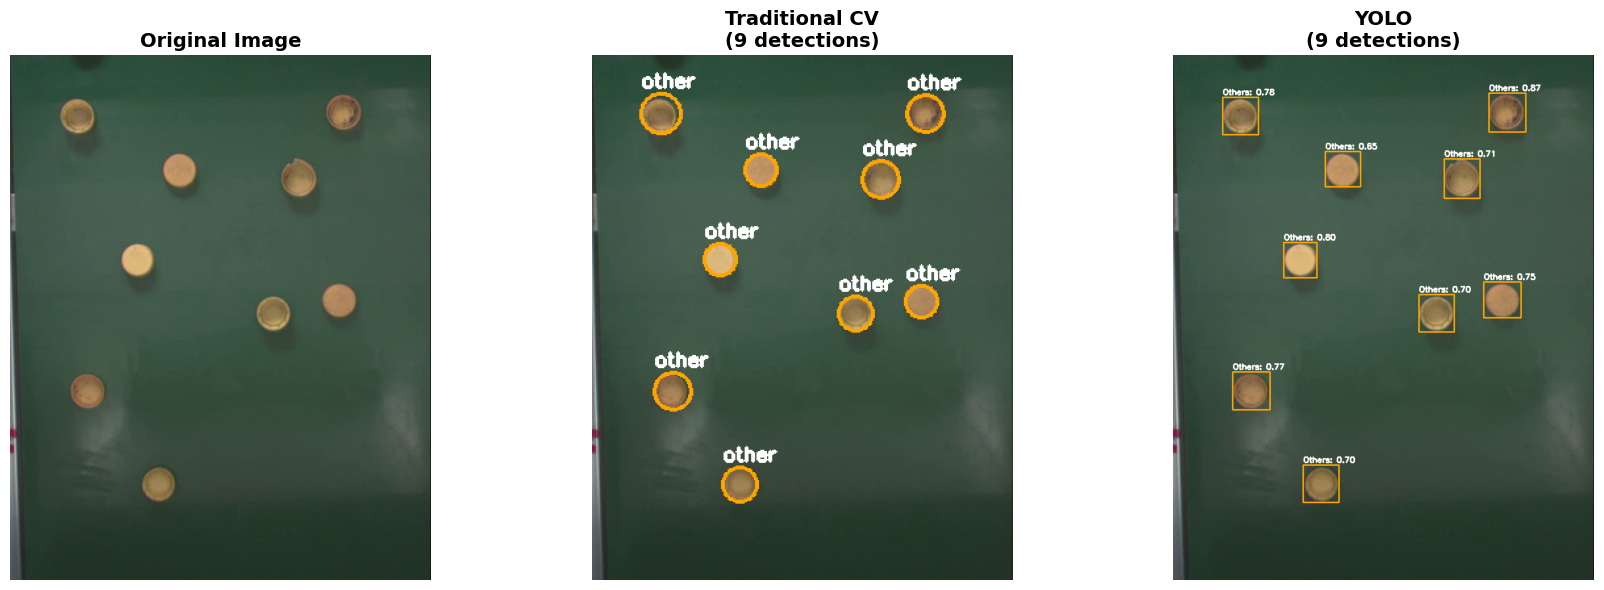


raw-250110_dc_s001_b3_3.jpg


/tmp/ipykernel_438957/684676510.py:62: RuntimeWarning: overflow encountered in scalar subtract
  output, label, (x - r, y - r - 5),


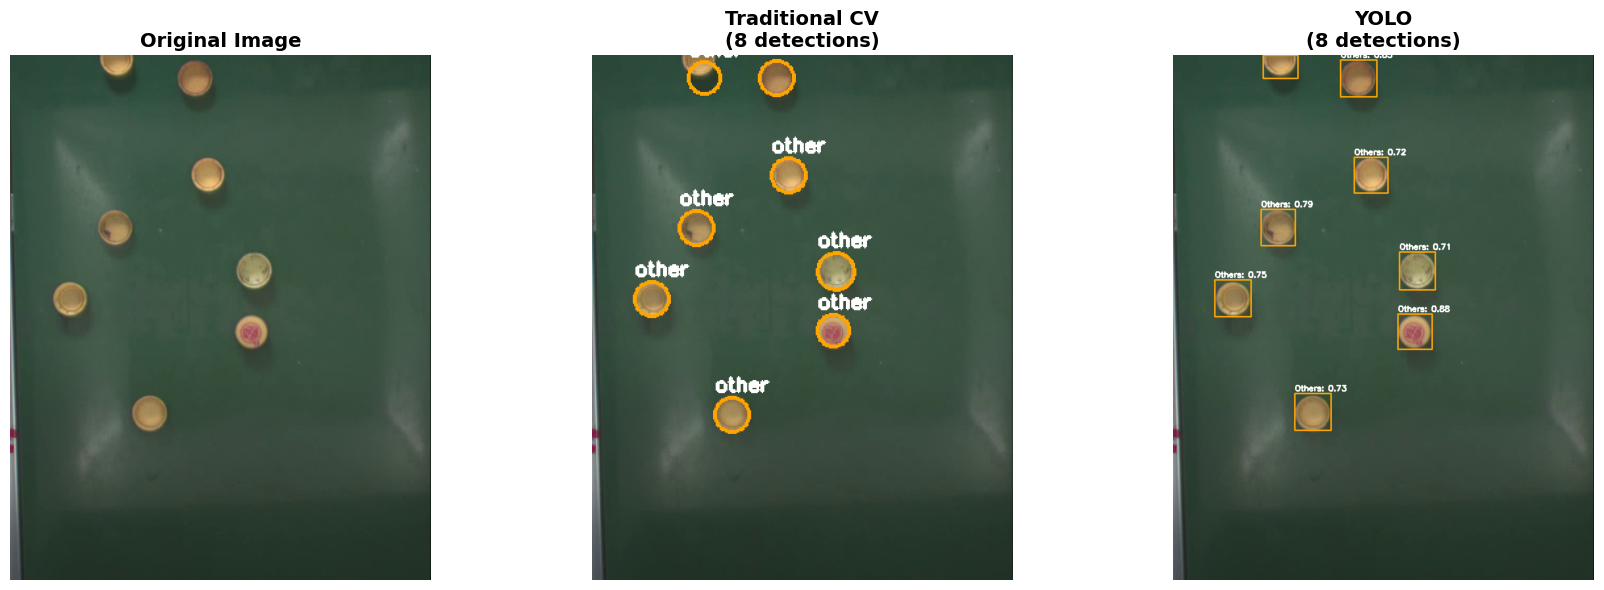


raw-250110_dc_s001_b3_4.jpg


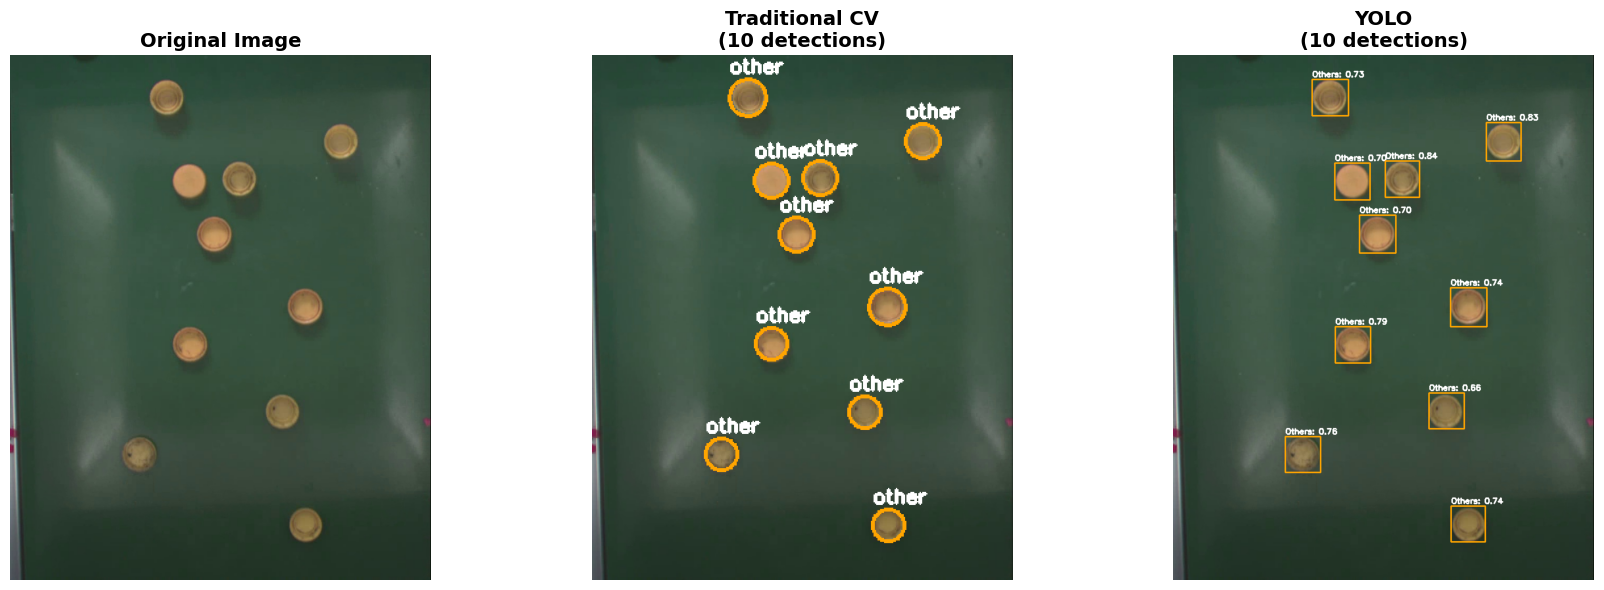


raw-250110_dc_s001_b4_1.jpg


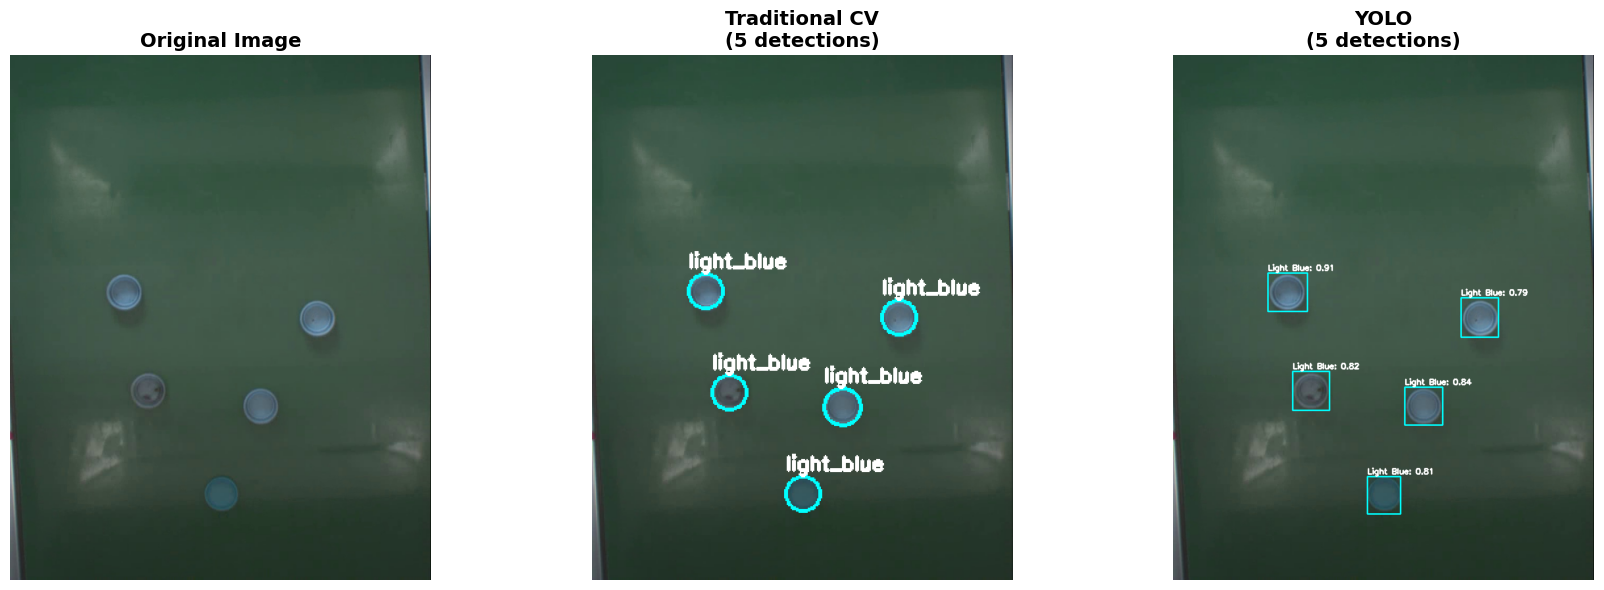


raw-250110_dc_s001_b4_2.jpg


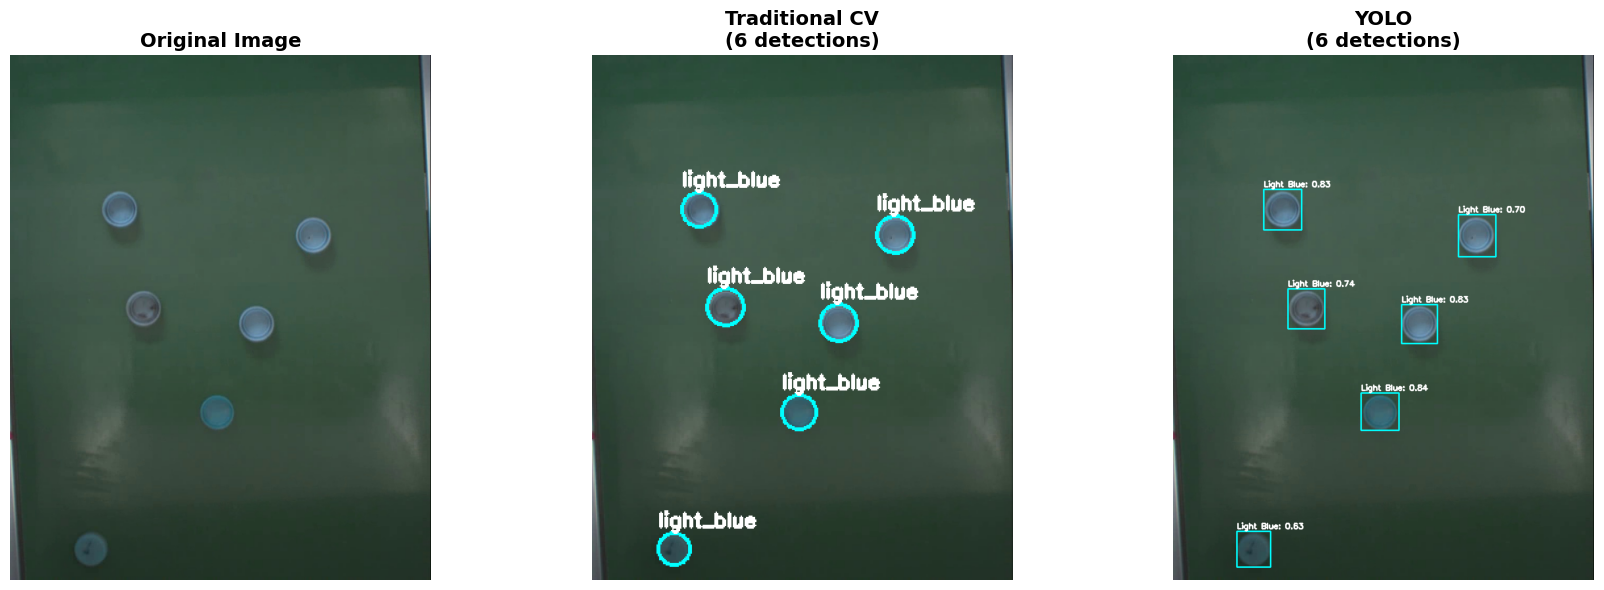


raw-250110_dc_s001_b4_3.jpg


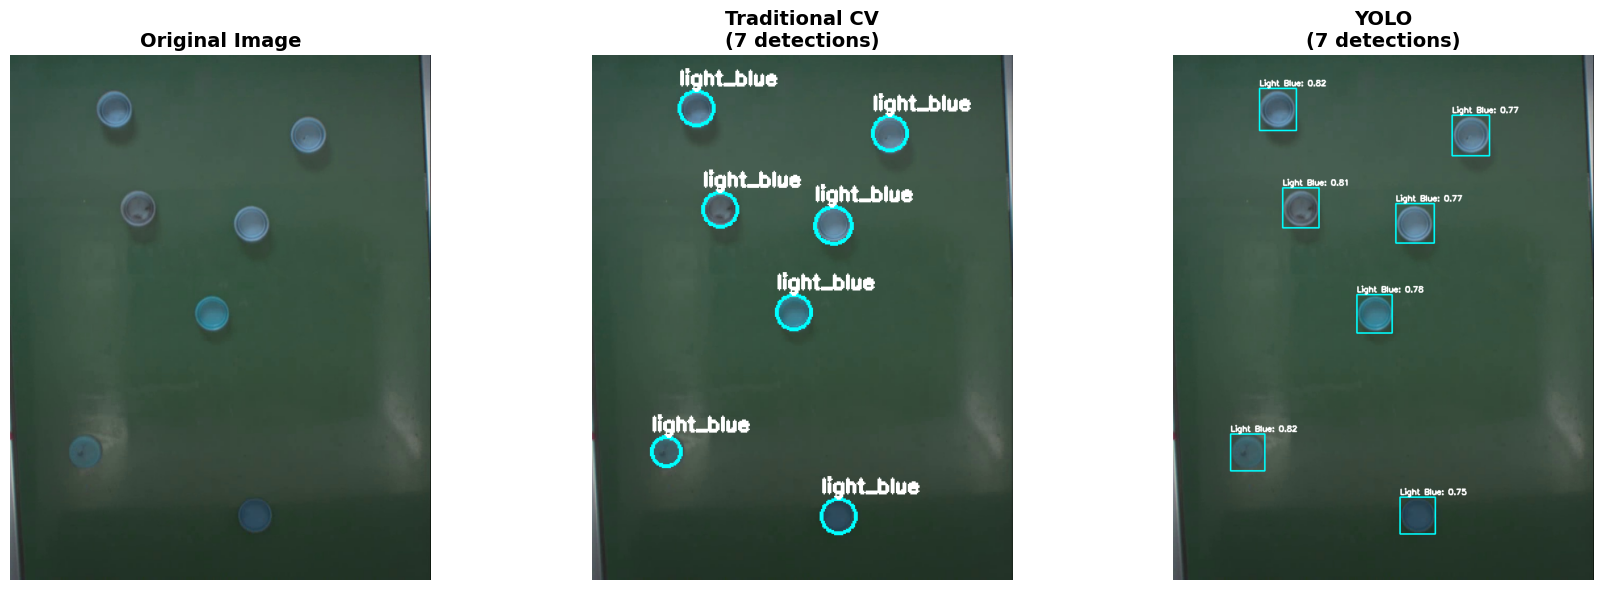


raw-250110_dc_s001_b5_2.jpg


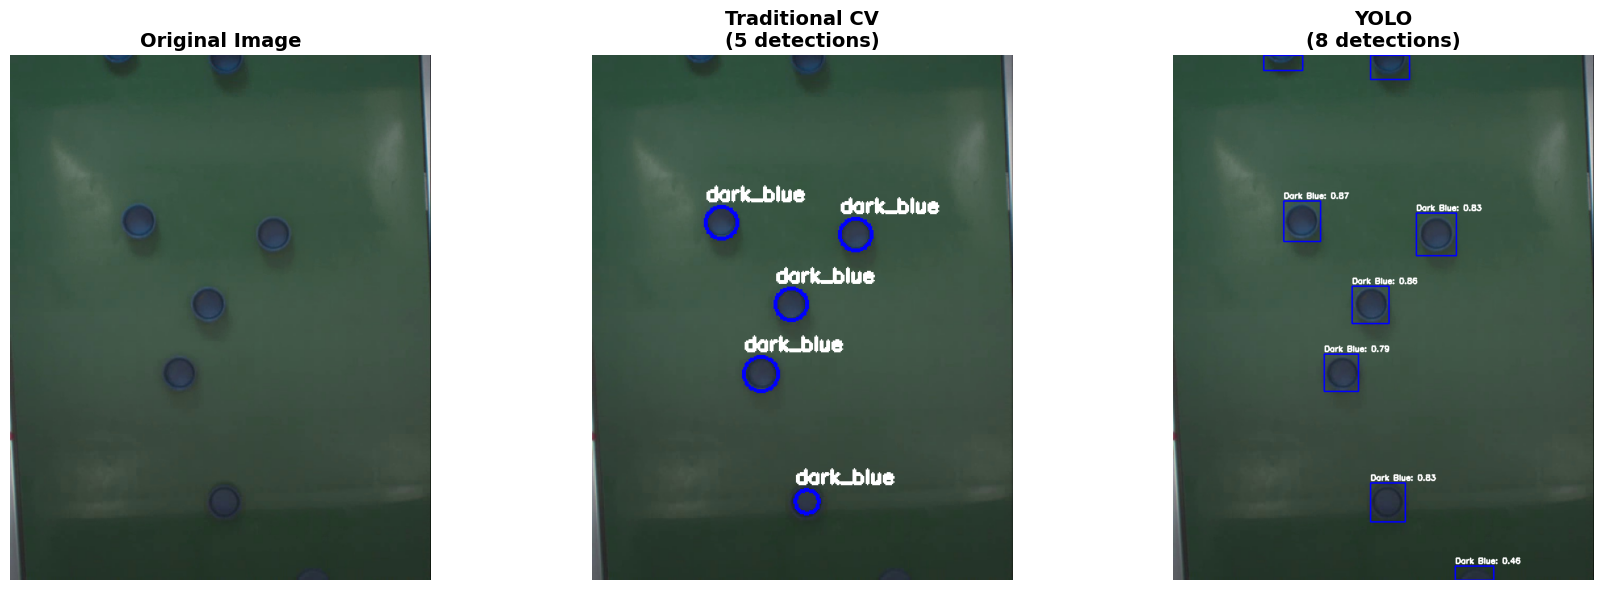


raw-250110_dc_s001_b5_3.jpg


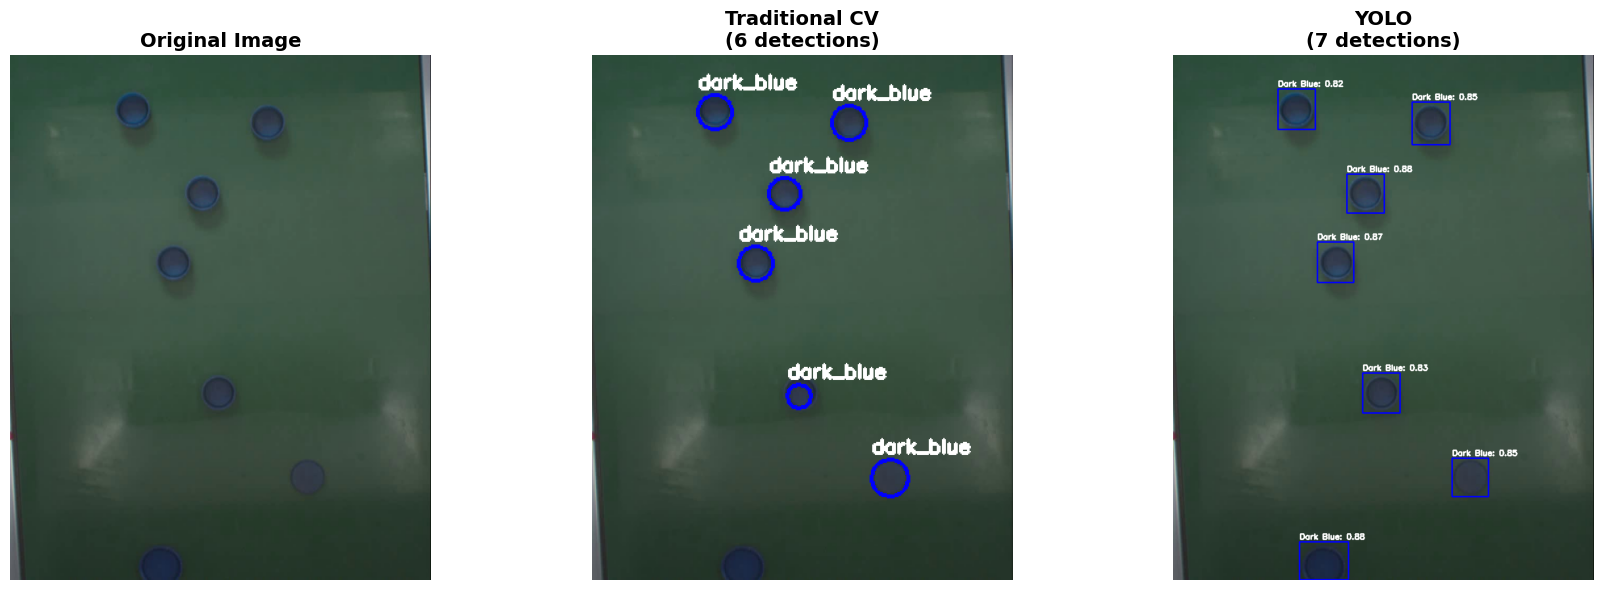


raw-250110_dc_s001_b5_5.jpg


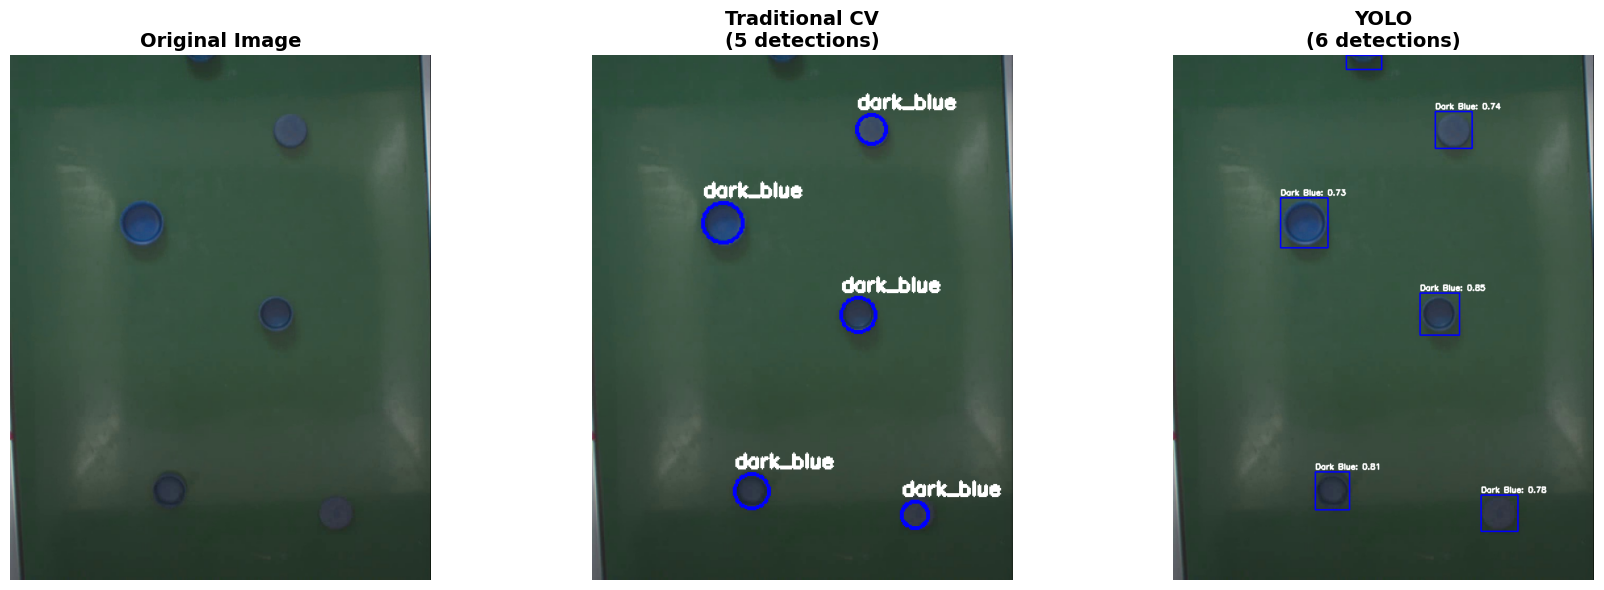

In [47]:
def visualize_comparison(img_path, trad_fn, yolo_fn, **yolo_kwargs):
    """Show side-by-side comparison of both approaches.
    
    Args:
        img_path: Path to image
        trad_fn: Traditional detection function
        yolo_fn: YOLO detection function
        **yolo_kwargs: Arguments for YOLO function
    """
    # Original image
    img = cv2.imread(img_path)

    # Traditional approach
    trad_dets, trad_vis = trad_fn(img_path)

    # YOLO approach
    yolo_dets, yolo_vis = yolo_fn(img_path, **yolo_kwargs)

    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image', fontsize=14, fontweight='bold')
    axes[0].axis('off')

    axes[1].imshow(cv2.cvtColor(trad_vis, cv2.COLOR_BGR2RGB))
    axes[1].set_title(
        f'Traditional CV\n({len(trad_dets)} detections)',
        fontsize=14, fontweight='bold'
    )
    axes[1].axis('off')

    axes[2].imshow(cv2.cvtColor(yolo_vis, cv2.COLOR_BGR2RGB))
    axes[2].set_title(
        f'YOLO\n({len(yolo_dets)} detections)',
        fontsize=14, fontweight='bold'
    )
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()


# Visualize comparisons on sample images
if 'yolo_metrics' in locals():
    print("Side-by-Side Comparison on Sample Images")
    print("=" * 70)
    print()
    
    sample_images = val_images
    
    for img_path in sample_images:
        print(f"\n{Path(img_path).name}")
        visualize_comparison(
            img_path,
            detect_and_classify_traditional,
            detect_and_classify_yolo,
            model_path=MODEL_PATH
        )
else:
    print("YOLO model not loaded. Cannot generate qualitative comparison.")
    print("Please set MODEL_PATH and re-run the evaluation section.")

---
# Conclusion

## Key Findings

- As you can see from the result above, both deep learning with yolov11n and computer vision with Hough circle + HSV analysis have good result.
- Yolo model might cause false positive when foreign object enter the image since the dataset lack of diverse background.
- Hough circle method might detect the shadow instead of the cap if the cap is partially visible.
- Hough circle + HSV analysis method has much faster inference time (average < 10ms) compared to YOLO (average 59.54ms)

## Which Approach is Better

- In this case, although both approch produce similar result in terms of accuracy, Hough Circle Transform with HSV Analysis is better because it succeed in fullfiling the inference speed time requirement. 

## Future Improvements

### Dataset
- Improve the quantity of the dataset. The current dataset is too small to do proper training.
- Improve the variety of the dataset. The objects of each image in the dataset is too homogeneous, each image contain the same variety of color which can cause model bias to cluster the same type in single image.
- Add more foreign object and background variety (optional, only if the deployment environment is not controlled).

### Deep Learning
- Try different model such as nanodet for faster inference

### Traditional Computer Vision
- Try different method such as background extraction with MOG2 to detect the bottle caps since the environment is controlled.